In [1]:
from heuristic.trainNetwork import TrainNetwork
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import traceback
from typing import List,Dict,Optional
from pydantic import BaseModel
from random import shuffle
from folium import folium , Marker, PolyLine, CircleMarker
from IPython.display import clear_output

In [2]:
trainNetwork = TrainNetwork()
trainNetwork.load("./heuristic/trainNetwork.save.json")
v = trainNetwork.getRandomVerticesID(2)
samplePath = trainNetwork.breadthFirstSearch(v.get("res")[0],v.get("res")[1]).get("res").get("path")

sampleResult = [trainNetwork.vertices[stationID] for stationID in samplePath ]

sampleCentroid= [
    sum([float(res.get("coordinate").get("lat")) for res in sampleResult])/len(sampleResult),
    sum([float(res.get("coordinate").get("lon")) for res in sampleResult])/len(sampleResult)
]

sampleCoordinate = [ 
    [
        float(res.get("coordinate").get("lat")),
         float(res.get("coordinate").get("lon")) 
    ]
     for res in sampleResult
]

SampleMap = folium.Map(location = sampleCentroid, zoom_start = 12) 
PolyLine(sampleCoordinate,color="red", weight=3.5, opacity=1).add_to(SampleMap)
for i in range(len(sampleCoordinate)):
    CircleMarker(location=sampleCoordinate[i],radius=3,color='red',fill=True,fill_color='red').add_to(SampleMap)
    if(i==0 or i == len(sampleCoordinate)-1):   
        Marker(location= sampleCoordinate[i]).add_to(SampleMap)

SampleMap

loaded edges and vertices


# Particle Swarm Optimization

In [3]:
class Solution(BaseModel):
    solution: List[str]
    distance: int
    remark:Optional[str]
        
# Particel class
class Particle:
    def __init__(self,_id:int,data:List[str],distanceGraph:dict,startID:int,endID:int):
        self.personal_best_record:dict = None
        self.current_solution:dict = None
        self.distanceGraph = distanceGraph
        self.data = data
        self._id = _id
        self.startID = startID
        self.endID = endID
        self.particleLocation = {}
        
    def spawn(self):
        try:
            data = self.data.copy()
            shuffle(data)
            
            solnData = [self.startID] + data + [self.endID]
            distance = sum([ self.distanceGraph[solnData[i-1]][solnData[i]] for i in range(1,len(solnData))])
            self.particleLocation["distance"] = distance
            self.particleLocation["solution"] = data
            self.particleLocation["encoded"] = []
            while len(self.particleLocation["encoded"]) != len(data):
                encode = {}
                for i in range(len(self.data)):
                    encode[self.data[i]] = 1/len(self.data[i]) if self.data[i] == data[i] else 0
                self.particleLocation["encoded"].append(encode)   
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return f"{str(error)} ... error at Particle.spawn() \n"
                                 
        
    def travel(self,velocityGraph:dict,global_best_location,interation_best_location):
        try:
            current = self.particleLocation["solution"].copy()
            swarmBest = interation_best_location["solution"].copy()
            globalBest = global_best_location["solution"].copy()
            
            r1,r2 = int(np.floor(np.random.rand()*len(globalBest))),int(np.floor(np.random.rand()*len(globalBest)))
            while r1==r2:
                r2 = int(np.floor(np.random.rand()*len(globalBest)))
            r3,r4 = int(np.floor(np.random.rand()*len(swarmBest))),int(np.floor(np.random.rand()*len(swarmBest)))
            while r3==r4:
                r4 = int(np.floor(np.random.rand()*len(swarmBest)))
            idx1,idx2 = min(r1,r2),max(r1,r2)
            idx3,idx4 = min(r3,r4),max(r3,r4)
            
            chance = np.random.rand()
            propotion = np.random.rand()
            exponential = propotion*(1/self.particleLocation["distance"]-1/interation_best_location["distance"])+(1-propotion)*(1/global_best_location["distance"]-1/self.particleLocation["distance"])
            metropolis_criterion = np.exp(-1*exponential)
            if chance < metropolis_criterion:
                localFeature = [current[i] for i in range(idx1,idx2)]
                if chance >= 0.5:
                    globalFesture = [globalBest[i] for i in range(idx3,idx4) if globalBest[i] not in localFeature]
                    swarmFeature = [d for d in swarmBest if d not in [*localFeature,*globalFesture]]
                else:
                    swarmFeature = [swarmBest[i] for i in range(idx3,idx4) if swarmBest[i] not in localFeature]
                    globalFesture = [d for d in globalBest if d not in [*localFeature,*swarmFeature]]
            else:
                if chance >=0.5:
                    globalFesture = [globalBest[i] for i in range(idx1,idx2)]
                    swarmFeature = [swarmBest[i] for i in range(idx3,idx4) if swarmBest[i] not in globalFesture]
                    localFeature = [d for d in current if d not in [*globalFesture,*swarmFeature]]
                else:
                    swarmFeature = [swarmBest[i] for i in range(idx1,idx2)]
                    globalFesture = [globalBest[i] for i in range(idx3,idx4) if globalBest[i] not in swarmFeature]
                    localFeature = [d for d in current if d not in [*globalFesture,*swarmFeature]]
            
            proposed_soln = globalFesture+swarmFeature+localFeature
             
            newSoln = proposed_soln   
            solnData =  [self.startID] + newSoln + [self.endID] 
            distance = sum([ self.distanceGraph[solnData[i-1]][solnData[i]] for i in range(1,len(solnData))])
            
            solution = {
                "solution":newSoln,
                "distance":distance,
                "remark": f" particle no {self._id}",
            }
            self.current_solution = solution
            if(self.personal_best_record is None): self.personal_best_record = solution
            if(self.personal_best_record["distance"] > solution["distance"]): self.personal_best_record = solution
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return f"{str(error)} ... error at Particle.travel() \n"
            
        
        
        

In [4]:
class ParticleSwarm:
    def __init__(self,graph:TrainNetwork,data:List[str],startVerticesID:str,endVerticesID:str):
        self.graph = graph
        self.data = [d for d in data if d!=startVerticesID and d!=endVerticesID].copy()
        self.startVerticesID = startVerticesID
        self.endVerticesID = endVerticesID
        self.distanceGraph = {}
        self.velocityGraph = {}
    
    def initiateDistanceGraph(self):
        try:
            locations = [self.startVerticesID] + self.data + [self.endVerticesID]
            distanceGraph = {}
            for fromLoc in locations:
                if  distanceGraph.get(fromLoc) is None:  distanceGraph[fromLoc] = {} 
                for toLoc in locations:
                    if fromLoc==toLoc:
                        distanceGraph[fromLoc][toLoc] = 0
                    else:
                        travel = self.graph.breadthFirstSearch(fromLoc,toLoc)
                        if(travel.get("err")): raise travel.get("err")
                        distanceGraph[fromLoc][toLoc] =len(travel.get("res").get("path"))
            self.distanceGraph = distanceGraph
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return f"{str(error)} ... error at ParticleSwarm.initiateDistanceGraph() \n"          
            
        
    def Train(self,population:int, iteration:int,inertia:float, personalInfluence:float, socialInfluence:float):
        try :
            # intiate environment setup
            errInitDist = self.initiateDistanceGraph()
            if(errInitDist is not None): raise Exception(errInitDist)
                
            # initiate population
            particles = [
                Particle(
                    pid,
                    self.data,self.distanceGraph, 
                    self.startVerticesID,
                    self.endVerticesID
                ) 
                for pid in range(population)
            ]
            
            
            # initiate variable
            global_best_location = None
            interation_best_location = None
            distance_record = []
            global_best_record = []
            iteration_record = []
            
            #particle spawn
            for particle in particles:
                spawnErr = particle.spawn()
                if spawnErr is not None: raise Exception(spawnErr)
                if global_best_location is None: global_best_location = particle.particleLocation
                if global_best_location["distance"]<particle.particleLocation["distance"]: global_best_location = particle.particleLocation
                if interation_best_location is None: interation_best_location = particle.particleLocation
                if interation_best_location["distance"]<particle.particleLocation["distance"]: interation_best_location = particle.particleLocation
                    
            #iteration
            for i in range(iteration):
                best_particle_solution = None
                
                #travel
                for particle in particles:
                    travelErr = particle.travel(self.velocityGraph,global_best_location,interation_best_location)
                    if(travelErr is not None): raise Exception(travelErr)
                    if(best_particle_solution is None): best_particle_solution = particle.current_solution
                    if(best_particle_solution["distance"]>particle.current_solution["distance"]): best_particle_solution = particle.current_solution
                    if(global_best_location is None): global_best_location = particle.current_solution
                    if(global_best_location["distance"]>particle.current_solution["distance"]): 
                        global_best_location = particle.current_solution
                        global_best_location["remark"] = "global best"
            

                    
                #reporting
                distance_record.append(best_particle_solution["distance"])
                global_best_record.append(global_best_location["distance"])
                iteration_record.append(i)
                
                #plot graph
                clear_output(wait=True)
                plt.xlabel('iteration')
                plt.ylabel('number of station used')
                plt.plot(iteration_record, distance_record, label="social influence")
                plt.plot(iteration_record, global_best_record,  label="personal influence")
                plt.legend()
                plt.show()
            
            res = [global_best_location]+[p.current_solution for p in particles]
            res.sort(key=lambda p: p["distance"])
            return res, None
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return None,f"{str(error)} ... error at ParticleSwarmOptimization.Train \n"
            

# Generation Test Data

In [5]:
stationIDs = trainNetwork.getRandomVerticesID(10).get("res")
# stationIDs = ['AG16','KJ35','AG11','PY21','AG1','PY27','PY22','KG33','KJ5','KJ9','SP8','KJ19','AG6','KG17','AG7','KG34','PY37','SP4','SP14','KJ6']
pd.DataFrame([trainNetwork.vertices[stationID] for stationID in stationIDs])

,id,stationName,coordinate
0,PY11,Jinjang,"{'lat': '3.2095', 'lon': '101.6558'}"
1,PY27,Kuchai,"{'lat': '3.08970', 'lon': '101.69428'}"
2,PY20,Ampang Park,"{'lat': '3.16163', 'lon': '101.71797'}"
3,PY22,Conlay,"{'lat': '3.15049', 'lon': '101.71859'}"
4,SP21,Alam Sutera,"{'lat': '3.0546753', 'lon': '101.6565324'}"
5,SP7,Masjid Jamek,"{'lat': '3.14940', 'lon': '101.69646'}"
6,KJ2,Taman Melati,"{'lat': '3.21956', 'lon': '101.72189'}"
7,KJ11,Kampung Baru,"{'lat': '3.1613213', 'lon': '101.7067252'}"
8,KJ19,Universiti,"{'lat': '3.1145746', 'lon': '101.6617999'}"
9,PY13,Kampung Batu,"{'lat': '3.20482', 'lon': '101.6756'}"


# Model Fitting

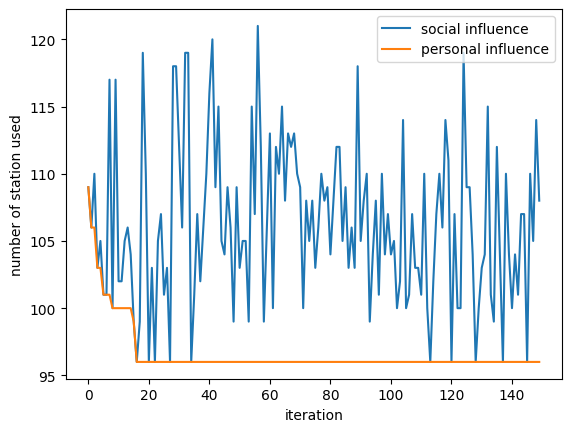

In [6]:
start = stationIDs[0]
end = stationIDs[0]

# Hyperparameter
populationSize=len(stationIDs)
iteration=150
personalInfluence=1
socialInfluence=1
inertia = 1

#Model
pso = ParticleSwarm(trainNetwork,stationIDs,start,end)
solution,err = pso.Train(populationSize, iteration, inertia, personalInfluence, socialInfluence)
if(err is not None): print(err)

In [7]:
result = [ s for s in solution ]
pd.DataFrame(result)

,solution,distance,remark
0,"[PY13, KJ11, KJ19, SP7, PY27, SP21, PY22, KJ2,...",96,global best
1,"[PY27, SP21, PY22, SP7, KJ2, PY20, KJ11, KJ19,...",108,particle no 8
2,"[KJ11, KJ19, PY13, PY22, PY20, SP7, PY27, SP21...",123,particle no 0
3,"[PY13, KJ11, KJ19, PY27, PY22, PY20, SP7, KJ2,...",123,particle no 6
4,"[PY27, SP21, KJ19, PY13, KJ11, KJ2, SP7, PY22,...",123,particle no 9
5,"[KJ19, SP7, SP21, KJ2, PY13, KJ11, PY22, PY27,...",126,particle no 3
6,"[KJ11, SP7, SP21, PY22, KJ2, PY20, PY13, PY27,...",126,particle no 7
7,"[KJ19, SP21, PY20, PY13, KJ2, PY22, PY27, KJ11...",128,particle no 2
8,"[KJ19, PY22, PY27, KJ11, SP7, PY13, KJ2, PY20,...",130,particle no 4
9,"[PY20, KJ19, PY13, KJ11, SP7, SP21, KJ2, PY27,...",130,particle no 5


In [8]:
soln = [trainNetwork.vertices.get(stationID) for stationID in result[0].get("solution")]
pd.DataFrame(soln)

,id,stationName,coordinate
0,PY13,Kampung Batu,"{'lat': '3.20482', 'lon': '101.6756'}"
1,KJ11,Kampung Baru,"{'lat': '3.1613213', 'lon': '101.7067252'}"
2,KJ19,Universiti,"{'lat': '3.1145746', 'lon': '101.6617999'}"
3,SP7,Masjid Jamek,"{'lat': '3.14940', 'lon': '101.69646'}"
4,PY27,Kuchai,"{'lat': '3.08970', 'lon': '101.69428'}"
5,SP21,Alam Sutera,"{'lat': '3.0546753', 'lon': '101.6565324'}"
6,PY22,Conlay,"{'lat': '3.15049', 'lon': '101.71859'}"
7,KJ2,Taman Melati,"{'lat': '3.21956', 'lon': '101.72189'}"
8,PY20,Ampang Park,"{'lat': '3.16163', 'lon': '101.71797'}"


In [9]:
stations = result[0].get("solution")
paths = []
for i in range(len(stations)):
    if i > 0:
        from_id = stations[i-1]
        to_id = stations[i]
        travelRes = trainNetwork.breadthFirstSearch(fromID=from_id,toID=to_id)
        if(travelRes.get("err")) : print(travelRes)
        paths.append(travelRes.get("res").get("path"))

# print({"from":stations[0],"to":stations[len(stations)-1]})
allPath = []
for path in paths:
    if len(allPath)>0 : path.pop(0)
    allPath+=path

In [10]:
pathData = [trainNetwork.vertices[stationID] for stationID in allPath]
locations = [
    {
        "location":[
            float(path_data.get("coordinate").get("lat")),
            float(path_data.get("coordinate").get("lon"))
        ],
        "popup":path_data.get("stationName")
    }
    for path_data in pathData
]

lat = 0
lon = 0
points = []
for loc in locations:
    lat += loc.get("location")[0]
    lon += loc.get("location")[1]
    points.append(loc.get("location"))
centrold = [lat/len(locations),lon/len(locations)]

Map =  folium.Map(location=centrold, zoom_start = 12)
PolyLine(points,color="red", weight=3.5, opacity=1).add_to(Map)

for loc in locations:
     CircleMarker(
        location=loc.get("location"),
        popup=loc.get("popup"),
        radius=3,
        color='red',
        fill=True,
        fill_color='red'
   ).add_to(Map)
        
for i in range(len(stations)):
    node = trainNetwork.vertices.get(stations[i])
    Marker(
        location=[
            float(node.get("coordinate").get("lat")),
            float(node.get("coordinate").get("lon"))
        ], 
        popup=f'{str(i+1)} - {node.get("stationName")}',
    ).add_to(Map)
    
     
Map